In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pystac_client import Client, ItemSearch
import planetary_computer as pc
import rasterio as rio
import rioxarray as xrio
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed

from ms_waterdetect import open_image, search_img, bands_to_columns, find_best_k, clusterize, calc_clusters_params, itendify_water_cluster, \
                        WaterDetect, calc_normalized_difference, generalize, search_tiles

# Getting the Image to be Processed

In [3]:
# from dask_gateway import GatewayCluster
# cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.

# client = cluster.get_client()

# cluster.adapt(minimum=4, maximum=24)
# print(cluster.dashboard_link)

In [4]:
#initial parameters

# coordinates of the image in (long, lat)
# coords = (-49.5, -23) # Paranapanema "2020-12-18
coords = (1.43, 43.6)


In [5]:
# get the images... if more than 1 image is located, get the first
# imgs = search_img(coords=coords, date="2021-08-18/2021-08-25")
# img_item = imgs[0]
# img_item

In [6]:
tile = search_tiles('30TXQ', '2018-09-11')[0]

In [7]:
tile

<Item id=S2A_MSIL2A_20180911T105621_R094_T30TXQ_20201008T235805>

# Create WD Instance

In [ ]:
cluster_bands = ['mndwi', 'ndwi', 'B12']
%time wd = WaterDetect(tile, cluster_bands, n_jobs=4)
wd

In [11]:
'massk' in wd.img

False

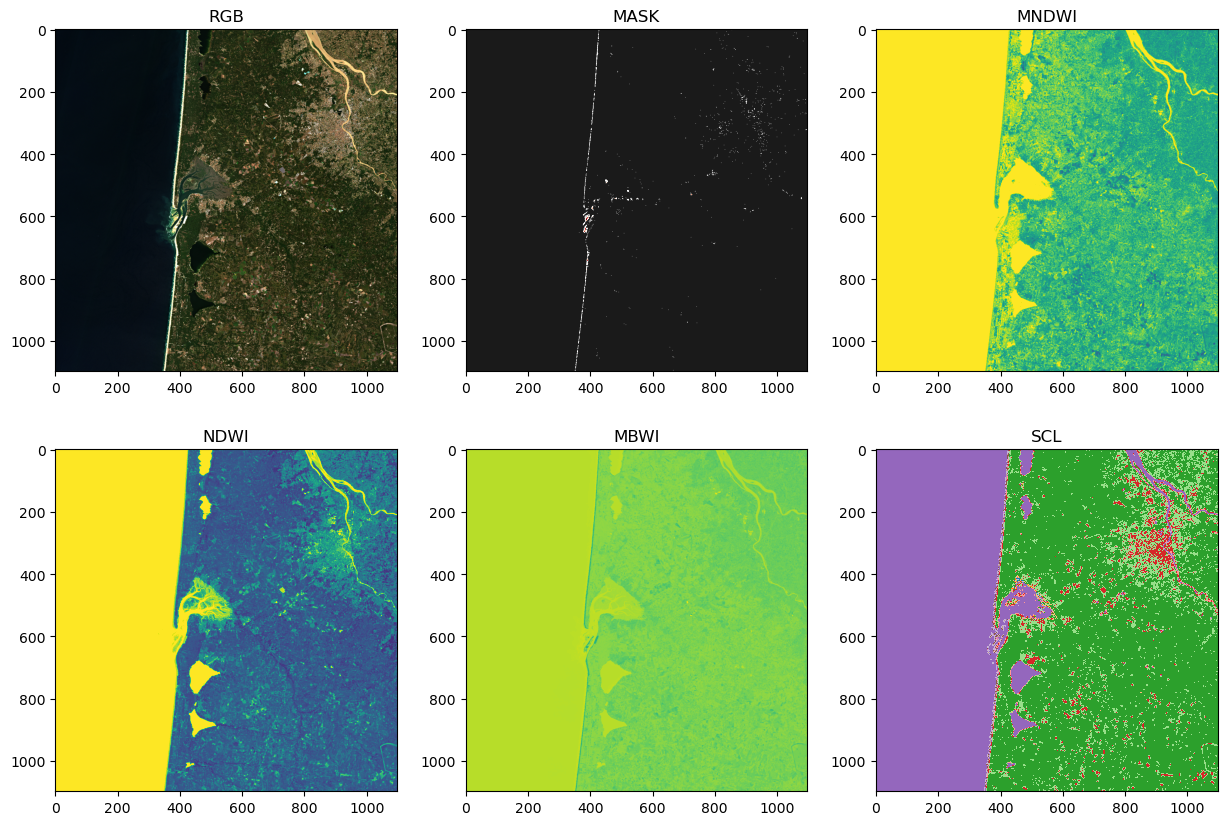

In [12]:
fig = wd.plot_thumbs(cols=3, bands=['rgb', 'mask', 'mndwi', 'ndwi', 'mbwi', 'SCL'])

# Detect Water

In [48]:
%time wd.run_detect_water(save=True)

k=2 - Calinski=69694.23832320653
k=3 - Calinski=36729.15550457208
k=4 - Calinski=24508.539094805998
k=5 - Calinski=19718.4847636373
k=6 - Calinski=21962.64580190818
k=7 - Calinski=19346.983359294136
Final clustering with k=2
Water cluster = 1
Generalized for the whole scene
Finalized. Access .water_mask or .cluster_matrix for final result
CPU times: user 34.3 s, sys: 11.3 s, total: 45.6 s
Wall time: 53.2 s


In [14]:
wd.cluster_params.loc['mean']

,B02,B03,B04,B11,B12,B08,SCL,mndwi,ndwi,mbwi,mask
0,0.105303,0.196994,0.191078,0.705930,0.421526,0.946156,4.118833,-0.325065,-0.662771,-4.676751e-05,0.0
1,0.080271,0.070597,0.041670,0.015996,0.013062,0.031583,5.991048,0.706053,0.645578,9.714710e-07,0.0


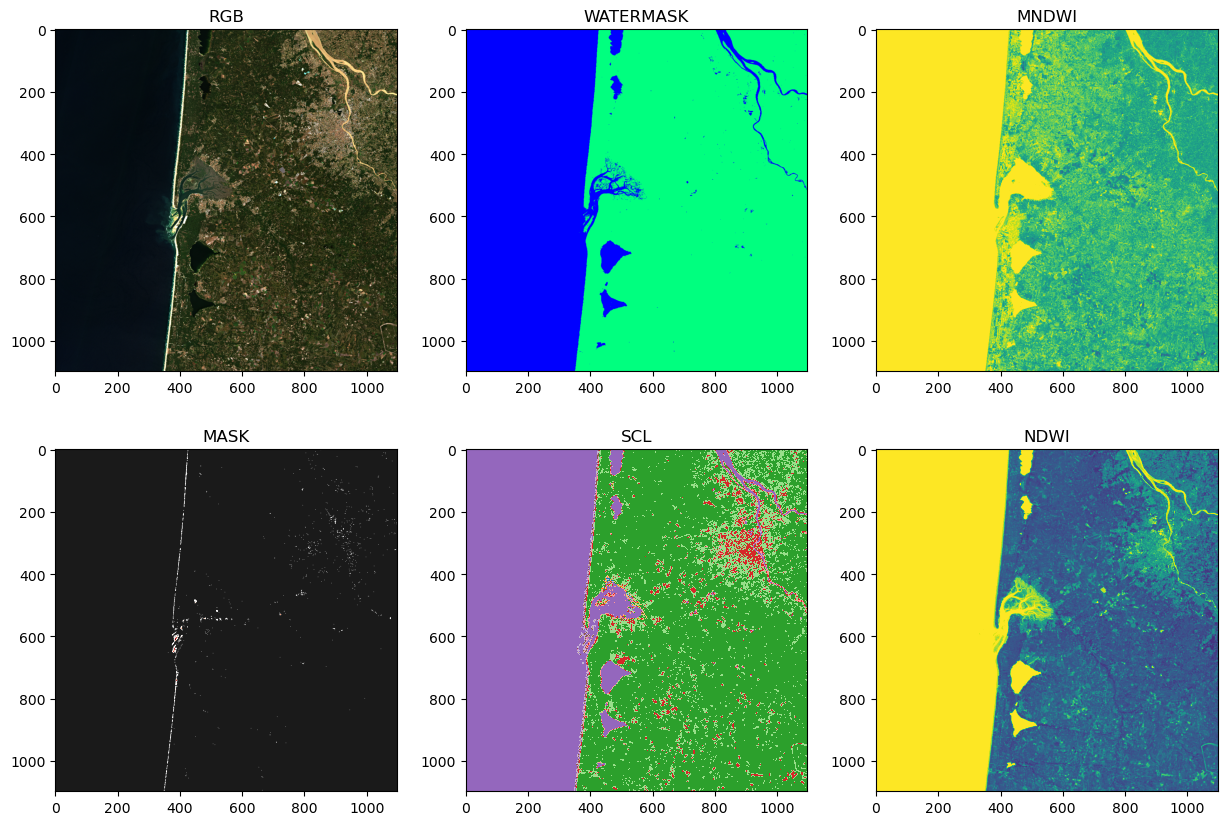

In [15]:
wd.plot_thumbs(cols=3, bands=['rgb', 'watermask', 'mndwi', 'mask', 'SCL', 'ndwi'], save=True)

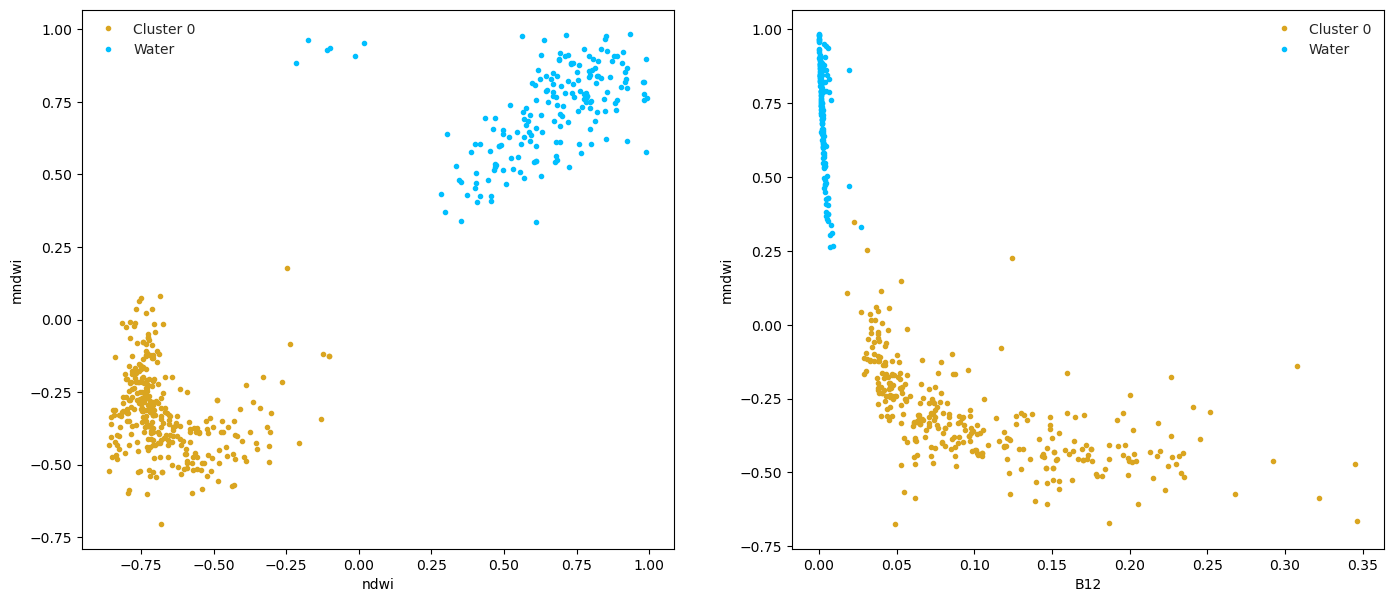

In [17]:
wd.plot_graphs([['ndwi', 'mndwi'], ['B12', 'mndwi']], cols=2, save=False)

# Automating WaterDetection

In [4]:
imgs = \
['/home/qt/rebellm/scratch/Santiago/T30TXQ_20180911_Bordeaux_summer.tif',
'/home/qt/rebellm/scratch/Santiago/T30TXQ_20190223_Bordeaux_winter.tif',
'/home/qt/rebellm/scratch/Santiago/T30TXR_20190223_Gironde_winter.tif',
'/home/qt/rebellm/scratch/Santiago/T30TYQ_20190223_Marmande_winter.tif',
'/home/qt/rebellm/scratch/Santiago/T30UXU_20180708_Bretagne_summer.tif',
'/home/qt/rebellm/scratch/Santiago/T30UXU_20190223_Bretagne_winter.tif',
'/home/qt/rebellm/scratch/Santiago/T30UYV_20200324_Havre_spring.tif',
'/home/qt/rebellm/scratch/Santiago/T31TCH_20181023_Ariege_summer.tif',
'/home/qt/rebellm/scratch/Santiago/T31TCH_20190322_Ariege_winter.tif',
'/home/qt/rebellm/scratch/Santiago/T31TCM_20180819_Chateauroux_summer.tif',
'/home/qt/rebellm/scratch/Santiago/T31TCM_20190225_Chateauroux_winter.tif',
'/home/qt/rebellm/scratch/Santiago/T31TFJ_20180927_Camargue_summer.tif',
'/home/qt/rebellm/scratch/Santiago/T31TFJ_20190331_Camargue_winter.tif',
'/home/qt/rebellm/scratch/Santiago/T31TFL_20190217_Ardeche_spring.tif',
'/home/qt/rebellm/scratch/Santiago/T31TFL_20190324_Ardeche_spring.tif',
'/home/qt/rebellm/scratch/Santiago/T31TFL_20190920_Ardeche_summer.tif',
'/home/qt/rebellm/scratch/Santiago/T31TGK_20190224_Alpes_winter.tif',
'/home/qt/rebellm/scratch/Santiago/T31TGL_20180828_Alpes_summer.tif',
'/home/qt/rebellm/scratch/Santiago/T31UEP_20190710_Orient_summer.tif',
'/home/qt/rebellm/scratch/Santiago/T31UEP_20191204_Orient_winter.tif',
'/home/qt/rebellm/scratch/Santiago/T31UEP_20191229_Orient_flood.tif',
'/home/qt/rebellm/scratch/Santiago/T31UFP_20190717_Der_summer.tif',
'/home/qt/rebellm/scratch/Santiago/T31UFP_20191204_Der_winter.tif',
'/home/qt/rebellm/scratch/Santiago/T31UFP_20191229_Der_flood.tif',
'/home/qt/rebellm/scratch/Santiago/T32ULU_20180912_Alsace_summer.tif',
'/home/qt/rebellm/scratch/Santiago/T32ULU_20190321_Alsace_winter.tif',
]

In [5]:
from pathlib import Path
paths = [Path(i) for i in imgs]

In [6]:
def get_tile_date(path):
    tile = path.stem[1:6]
    joined_date = path.stem.split('_')[1]
    date = '-'.join([joined_date[:4], joined_date[4:6], joined_date[6:8]])
    return tile, date

In [7]:
tiles = [search_tiles(*get_tile_date(path))[0] for path in paths]

In [8]:
cluster_bands = ['mndwi', 'ndwi', 'B12']

for tile in tiles:
    print('-'*50)
    print(f'Processing tile {tile}')
    wd = WaterDetect(tile, cluster_bands, n_jobs=4)
    wd.run_detect_water(save=True)
    
    # save thumbnails
    wd.plot_thumbs(cols=3, bands=['rgb', 'watermask', 'mndwi', 'mask', 'SCL', 'ndwi'], save=True)
    
    # save graphs
    wd.plot_graphs([['ndwi', 'mndwi'], ['B12', 'mndwi']], cols=2, save=True)

        

--------------------------------------------------
Processing tile <Item id=S2A_MSIL2A_20180911T105621_R094_T30TXQ_20201008T235805>
resampling B11 to (10980, 10980)
resampling B12 to (10980, 10980)
resampling SCL to (10980, 10980)
Calculating indices
k=2 - Calinski=66900.16134150444
k=3 - Calinski=35251.06233669262
k=4 - Calinski=25425.53264014528
k=5 - Calinski=19100.109872940706
k=6 - Calinski=15934.50732752069
k=7 - Calinski=13304.820159764135
Final clustering with k=2
Water cluster = 1
Generalized for the whole scene
Finalized. Access .water_mask or .cluster_matrix for final result
--------------------------------------------------
Processing tile <Item id=S2B_MSIL2A_20190223T110039_R094_T30TXQ_20201007T195701>
resampling B11 to (10980, 10980)
resampling B12 to (10980, 10980)
resampling SCL to (10980, 10980)
Calculating indices
k=2 - Calinski=5.046265508413306
k=3 - Calinski=51618.31790666873
k=4 - Calinski=35017.66793049481
k=5 - Calinski=35059.265511950754
k=6 - Calinski=31312.59

In [9]:
%debug

> /tmp/ipykernel_573/3948439588.py(3)<module>()
      1 cluster_bands = ['mndwi', 'ndwi', 'B12']
      2 
----> 3 for tile in tiles:
      4     print('-'*50)
      5     print(f'Processing tile {tile}')



ipdb>  q


In [10]:
len(tiles)

26